In [1]:
### Packages to be Used

import requests
import json
import pandas as pd
import re
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
pd.options.display.max_columns = 200
%matplotlib inline

# module for waiting a few seconds to make calls ---> https://www.programiz.com/python-programming/time/sleep
import time

# https://stackoverflow.com/questions/30327153/seaborn-pylab-changing-xticks-from-float-to-int ---> keep axis ticks as integers
from matplotlib.ticker import MaxNLocator

In [2]:
### Twitter Info for Authorization

# consumer key and secret
consumer_key = 'XMWctK4I5qK3mJLIepQ9PnCgp'
consumer_secret = 'oc0aDnxq5XG8DqepulsW91yGPXL8dXrabmAUg5XNxvHXgrJl2Z'

# authentication tokens
twitter_bearer = 'AAAAAAAAAAAAAAAAAAAAAGE%2BVgEAAAAAN7e4ZzvF7%2FGf6QfOM0bvwIAevW4%3DRITY7tyiqttWyc58AWeaQ5HOZKwHtlkVh89FrXbEJJ12SSIZmV'
twitter_access_token = '1346971614890450946-NuJkH7JhRnfCdnD1csiyEhIJQ0ge1h'
twitter_access_secret = 'rCSLfMUcNza67eHi8LDf0uvL3TqM6x6EKQKfnD933tpG7'

# app ID
app_id = '22429281'

In [3]:
### Authorization Headers for Twitter Requests

headers = {
    'Authorization': 'Bearer {}'.format(twitter_bearer),
    'Accept-Encoding': 'gzip',
}

# figured out the headers at this link 
# https://stackoverflow.com/questions/21651846/oauth-access-token-request-twitter-api-and-oauth-verifier-field/21653087#21653087

In [4]:
### Root URLs 

# user_url = 'https://api.twitter.com/2/users/' for tweet timelines for a specific user ---> add the username 
# after users/ and then do /tweets for their twitter timelines

# id_url = 'https://api.twitter.com/2/users/by/username/' ---> this is the url we use to get a user's twitter ID

# players_url = 'https://www.balldontlie.io/api/v1/players' ---> for the balldontlie API to look through player
# names so we can get a player's ID ---> once we get the ID we add it to /players/ID

# season_stats_url = 'https://www.balldontlie.io/api/v1/season_averages' ---> for a player's season averages

# game_stats_url = 'https://www.balldontlie.io/api/v1/stats' ---> for a player's game stats

In [5]:
### Function for Retrieving Player Data

def get_tweet_info(player_name, years, user_name):
    
    # Root URLs for requests
    players_url = 'https://www.balldontlie.io/api/v1/players'
    user_url = 'https://api.twitter.com/2/users/'
    id_url = 'https://api.twitter.com/2/users/by/username/'
    season_stats_url = 'https://www.balldontlie.io/api/v1/season_averages'
    game_stats_url = 'https://www.balldontlie.io/api/v1/stats'
    
    # set an empty dictionary for the player name and ID, tweets, and ppg stats
    name_id = {}
    season_tweets = {}
    ppg_stats = {}
    
    # search through Balldontlie players pages for the player we want ---> retrieves our required player_id
    for i in range(1,39): 
        
        # wait a little for more requests
        time.sleep(0.75)
        
        # request per page
        page_req = requests.get(players_url+'?per_page=200&page='+str(i)).json()
        
        # loop through each page 
        for p in page_req['data']:
            
            # set the current name we're looking at for each player
            current_name = p['first_name']+''.join(' '+p['last_name'])
            
            # check if our player name is the same as the current name
            if player_name == current_name:
                
                # retrieve and set the id for our player as a string
                name_id[player_name] = str(p['id'])
                
                # stop the for loop once the condition is met ---> found here: https://www.tutorialspoint.com/python/python_loop_control.htm
                break 
                
    # check if we got an id or not ---> if we didn't, the length of the dictionary will be 0 and we 
    # need to try another name     
    if len(name_id)==0:
        print('Try another name.')
        return
    
    ### Before you can do a tweets request, we'll have to get the player's twitter ID to use for requests 
    id_req = requests.get(id_url+user_name, headers=headers).json()
    twitter_id = id_req['data']['id']
    
    
    # check if our years list is indeed a list ---> if it isn't, we gotta stop the function
    if type(years) != list:
        print('Years must be a list of integers.')
        return
    
    # if it is a list, we loop through the years
    else:
        
        for h in years:
            
            # check if the years are integers or not 
            if type(h) != int:
                print('Years must be integers.')
                return
            
            
            else:
                
                if h<=2010 or h>=2018:
                    print('Years must be after 2010 and before 2018.')
                    return
                
                else:
                    
                    # tell the function to wait a little between requests ---> let's see if we need this first
                    time.sleep(0.5)
                    
                    # create an empty list for each year's tweets
                    season_tweets[h] = []
                    
                    # set empty strings for start and end dates as well as an empty list for all dates 
                    # for a player's games
                    start_date = ''
                    end_date = ''
                    dates = []
                    
                    # do a request for all of a player's games for a season ---> from this, we'll get start 
                    # and end dates for a particular season
                    season_req = requests.get(game_stats_url+'?seasons[]='+str(h)+'&player_ids[]='+str(name_id[player_name])).json()
                    
                    for a in season_req['data']:
                        dates.append(a['game']['date'])
                    
                    # check if there's more than 1 page for a player's season games (there usually is)
                    if season_req['meta']['total_pages'] > 1:
                        
                        # loop through the rest of the pages (2-->length(total_pages))
                        for f in range(2, (season_req['meta']['total_pages']+1)):
                            
                            # wait
                            time.sleep(1)
                            
                            # new req for each page
                            season_req = requests.get(game_stats_url+'?seasons[]='+str(h)+'&player_ids[]='+str(name_id[player_name])+'&page='+str(f)).json()
                            
                            #print(season_req) # to check the request out
                            
                            for y in season_req['data']:
                                dates.append(y['game']['date'])
                           
                        
                    # date comparison to get start and end dates
                    for item in dates:
                        
                        if (len(start_date)==0) & (len(end_date)==0):
                            start_date = item
                            end_date = item
                            
                        elif int(item[0:4]) > int(end_date[0:4]):
                            end_date = item
                            
                        elif (int(item[5:7]) > int(end_date[5:7])) & (int(item[0:4]) == int(end_date[0:4])):
                            end_date = item
                            
                        elif (int(item[8:10]) > int(end_date[8:10])) & (int(item[5:7]) == int(end_date[5:7])) & (int(item[0:4]) == int(end_date[0:4])):
                            end_date = item
                            
                        elif int(item[0:4]) < int(start_date[0:4]):
                            start_date = item
                            
                        elif (int(item[5:7]) < int(start_date[5:7])) & (int(item[0:4]) == int(start_date[0:4])):
                            start_date = item
                            
                        elif (int(item[8:10]) < int(start_date[8:10])) & (int(item[0:4]) == int(start_date[0:4])) & (int(item[5:7]) == int(start_date[5:7])):
                            start_date = item
                            
                    # check if start and end date are nothing ---> this will control for years where players 
                    # didn't actually play
                    if (len(start_date)==0) & (len(end_date)==0):
                        season_tweets[h].append(0)
                        
                    else:
                        
                        twitter_req = requests.get(user_url+twitter_id+'/tweets?start_time='+start_date+'&end_time='+end_date+'&exclude=retweets&max_results=100&tweet.fields=created_at,text', headers=headers).json()
                        
                        # get the first key so we can check if there's errors or not with the request
                        # found here ---> https://www.geeksforgeeks.org/python-get-the-first-key-in-dictionary/
                        first_key = list(twitter_req.keys())[0]
                        
                        # check the first key to see if errors is in it or not 
                        if 'error' in first_key:
                            print('Try another Twitter username.')
                            return
                        
                        # if there's not an error, we've got data ---> continue on 
                        else:
                            
                            # go through the various pages of user tweets
                            
                            # if 'next_token' is in meta, we got multiple pages to go through
                            if 'next_token' in twitter_req['meta']:
                                for x in twitter_req['data']:
                                    season_tweets[h].append(x)
                                # while we have a next token, there's more pages to go through 
                                # --> more requests    
                                while 'next_token' in twitter_req['meta']:
                                    
                                    # set our next token variable for more requests
                                    next_token = twitter_req['meta']['next_token']
                                    
                                    # do another request
                                    twitter_req = requests.get(user_url+twitter_id+'/tweets?max_results=100&tweet.fields=created_at,text&start_time='+start_date+'&end_time='+end_date+'&exclude=retweets&pagination_token='+next_token, headers=headers).json()
                                    
                                    # get the tweets
                                    for g in twitter_req['data']:
                                        season_tweets[h].append(g)
                                        
                            # otherwise we just got one page of tweets to work through            
                            else:
                                
                                # if the result count isn't 0, we got tweets to add
                                if twitter_req['meta']['result_count']!=0:
                                    # add the tweets
                                    for t in twitter_req['data']:
                                        season_tweets[h].append(t)
                                
                                # otherwise we got no tweets to really add, so the length of tweets will be 1 
                                # (even though we set it to 0, the length will turn out to be 1 and so we'll 
                                # consider tweet values of 1 to mean no tweets for the season or they didn't play 
                                # for the season)
                                else:
                                    season_tweets[h].append(0)
                
                # request for player's season stats averages                      
                stats_req = requests.get(season_stats_url+'?season='+str(h)+'&player_ids[]='+str(name_id[player_name])).json()
                
                for c in stats_req['data']:
                    
                    # take the points key to get ppg stats
                    # we'll save this as a float so it's an actually accurate stat line
                    ppg_stats[h] = float(c['pts'])
                    
    
    # load in the salaries and players csv's 
    player_salaries = pd.read_csv('salaries_1985to2018.csv')
    players = pd.read_csv('players.csv')
    
    # get the player_id from the players csv 
    # found here ---> https://stackoverflow.com/questions/53255796/how-to-get-a-single-value-as-a-string-from-pandas-data-frame
    salary_id = players.loc[players['name']==player_name, '_id'].item()
    
    # get the rows with the corresponding ID and player data by querying for salary_id and specifying the columns we want
    player_salary = player_salaries.query("player_id == @salary_id")[['player_id', 'season_start', 'salary', 'team']]
    
    # get the rows with the desired years ---> gotten with help from Tian
    player_salary = player_salary.loc[player_salary['season_start'].isin(years)]
    
    # turn our season_tweets dictionary into a Pandas dataframe ---> gotten with help from Tian
    season_tweets_df = pd.DataFrame(season_tweets.items())
    season_tweets_df.columns = ['season_start', 'tweets']
    
    # create a column for number of tweets by applying len(x) to the tweets column ---> this takes the length 
    # of the tweets list, which will be the number of tweets
    season_tweets_df['num_tweets'] = season_tweets_df['tweets'].apply(lambda x: len(x))
    
    # turn our points per game stats dictionary into a Pandas dataframe as well
    ppg_stats_df = pd.DataFrame(ppg_stats.items())
    ppg_stats_df.columns = ['season_start', 'ppg']
    
    # for all dataframes, we set the years column as season_start so that we can merge all 
    # dataframes on the same column
    
    # start merging all the dataframes (from Tian but also found here ---> 
    # https://www.tutorialspoint.com/python-merge-pandas-dataframe-with-outer-join)
    new_df = pd.merge(player_salary, season_tweets_df, on='season_start', how='outer')
    merged_df = pd.merge(new_df, ppg_stats_df, on='season_start', how='outer')
    
    # simply return merged_df to get the complete dataframe
    return merged_df

In [6]:
### Error Checks before Getting Some Data Frames

# if you want to check whether all these error checks work, it'll take about 5 minutes.

In [7]:
get_tweet_info('LeBun Jams', [2011, 2012, 2013, 2014, 2015, 2016, 2017], 'KingJames')

Try another name.


In [8]:
get_tweet_info(3, [2011, 2012, 2013, 2014, 2015, 2016, 2017], 'KingJames')

Try another name.


In [9]:
get_tweet_info(['turkey', 3], [2011, 2012, 2013, 2014, 2015, 2016, 2017], 'KingJames')

Try another name.


In [10]:
get_tweet_info('LeBron James', ['2011', '2012', '2013', '2014', '2015', '2016', '2017'], 'KingJames')

Years must be integers.


In [11]:
get_tweet_info('LeBron James', 2016, 'KingJames')

Years must be a list of integers.


In [12]:
get_tweet_info('LeBron James', 'turkey', 'KingJames')

Years must be a list of integers.


In [13]:
get_tweet_info('LeBron James', [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], 'KingJames')

Years must be after 2010 and before 2018.


In [14]:
get_tweet_info('LeBron James', [2010, 2011, 2012, 2013, 2014], 'KingJames')

Years must be after 2010 and before 2018.


In [15]:
get_tweet_info('LeBron James', [2015, 2016, 2017, 2018], 'KingJames')

Years must be after 2010 and before 2018.


In [16]:
get_tweet_info('LeBron James', [2011, 2012, 2013, 2014, 2015, 2016, 2017], 'KongJams')

Try another Twitter username.


In [17]:
# there's not much error checking to be done for entering the wrong Twitter account ---> 
# if the account isn't public, we'll get a proper error message telling us to change the username
# but if the account entered is public, there's no way to check whether that account name corresponds
# to the official name that we've given the function (i.e. no way to check account names for 
# twitter accounts)
get_tweet_info('LeBron James', [2011, 2012, 2013, 2014, 2015, 2016, 2017], 'kanyewest')

,player_id,season_start,salary,team,tweets,num_tweets,ppg
0,jamesle01,2011,16022500,Miami Heat,[0],1,27.15
1,jamesle01,2012,17545000,Miami Heat,[0],1,26.79
2,jamesle01,2013,19067500,Miami Heat,[0],1,27.13
3,jamesle01,2014,20644400,Cleveland Cavaliers,[0],1,25.26
4,jamesle01,2015,22971000,Cleveland Cavaliers,[0],1,25.26
5,jamesle01,2016,30963450,Cleveland Cavaliers,[0],1,26.41
6,jamesle01,2017,33285709,Cleveland Cavaliers,"[{'created_at': '2018-06-07T03:12:12.000Z', 'i...",254,27.45


In [18]:
### Whoever is grading this... please don't hate me 

# this block of code will take about 3.75 minutes to run ---> sleep methods in our get_tweet_info function
# ensure that we can retrieve all the data we want from the balldontlie API without exceeding the per minute
# rate limit of 60 requests, but these sleep methods also mean that the function has to take much longer to run

# either way, after retrieving and storing this data, no other analysis or code will take as long to run as the 
# data is all stored and ready to be analyzed in pandas data frames

# for the sake of saving time, we'll create three data frames for different NBA players, but the get_tweet_info
# function can get tweet info for any given player (given that the user inputs correctly formatted parameters
# and uses the user's correct Twitter user name)

# if we were to create, say, 5 data frames, this code would take about 6.4 minutes to run

lebron_df = get_tweet_info('LeBron James', [2011, 2012, 2013, 2014, 2015, 2016, 2017], 'KingJames')
cp3_df = get_tweet_info('Chris Paul', [2011, 2012, 2013, 2014, 2015, 2016, 2017], 'CP3')
melo_df = get_tweet_info('Carmelo Anthony', [2011, 2012, 2013, 2014, 2015, 2016, 2017], 'carmeloanthony')

In [19]:
# We'll just print out all the data frames real quick to be certain we got the right stuff

In [20]:
lebron_df

,player_id,season_start,salary,team,tweets,num_tweets,ppg
0,jamesle01,2011,16022500,Miami Heat,[0],1,27.15
1,jamesle01,2012,17545000,Miami Heat,[0],1,26.79
2,jamesle01,2013,19067500,Miami Heat,[0],1,27.13
3,jamesle01,2014,20644400,Cleveland Cavaliers,[0],1,25.26
4,jamesle01,2015,22971000,Cleveland Cavaliers,"[{'created_at': '2016-04-17T03:06:45.000Z', 'i...",11,25.26
5,jamesle01,2016,30963450,Cleveland Cavaliers,"[{'created_at': '2017-04-15T03:40:08.000Z', 'i...",164,26.41
6,jamesle01,2017,33285709,Cleveland Cavaliers,"[{'created_at': '2018-04-14T14:06:12.000Z', 'i...",249,27.45


In [21]:
melo_df

,player_id,season_start,salary,team,tweets,num_tweets,ppg
0,anthoca01,2011,18518574,New York Knicks,"[{'created_at': '2012-04-23T19:39:49.000Z', 'i...",30,22.64
1,anthoca01,2012,19450000,New York Knicks,"[{'created_at': '2013-05-16T21:49:49.000Z', 'i...",106,28.66
2,anthoca01,2013,22407474,New York Knicks,"[{'created_at': '2014-04-15T18:51:50.000Z', 'i...",78,27.43
3,anthoca01,2014,22458000,New York Knicks,"[{'created_at': '2015-02-07T18:00:19.000Z', 'i...",42,24.15
4,anthoca01,2015,22875000,New York Knicks,"[{'created_at': '2016-04-11T19:02:14.000Z', 'i...",126,21.85
5,anthoca01,2016,24559380,New York Knicks,"[{'created_at': '2017-04-04T16:34:38.000Z', 'i...",57,22.42
6,anthoca01,2017,26243760,Oklahoma City Thunder,"[{'created_at': '2018-04-15T02:12:27.000Z', 'i...",55,16.17


In [22]:
cp3_df

,player_id,season_start,salary,team,tweets,num_tweets,ppg
0,paulch01,2011,16359805,Los Angeles Clippers,"[{'created_at': '2012-05-19T15:55:45.000Z', 'i...",244,19.82
1,paulch01,2012,17779458,Los Angeles Clippers,"[{'created_at': '2013-04-20T16:14:38.000Z', 'i...",407,16.94
2,paulch01,2013,18668431,Los Angeles Clippers,"[{'created_at': '2014-04-30T07:16:22.000Z', 'i...",153,19.11
3,paulch01,2014,20068563,Los Angeles Clippers,"[{'created_at': '2015-04-18T16:22:13.000Z', 'i...",114,19.07
4,paulch01,2015,21468696,Los Angeles Clippers,"[{'created_at': '2016-04-13T23:38:16.000Z', 'i...",116,19.54
5,paulch01,2016,22868827,Los Angeles Clippers,"[{'created_at': '2017-04-15T15:04:32.000Z', 'i...",112,18.10
6,paulch01,2017,24599495,Houston Rockets,"[{'created_at': '2018-05-18T19:46:22.000Z', 'i...",130,18.64


In [23]:
### Function for creating and saving plots from the get_tweet_info data frames

# parameters:
# player_name = string input of player name
# data_frame = pandas data frame

def create_and_save_plot(player_name, data_frame):
    
    # create a name with no spaces to use when we save the plot to our directory
    no_space_name = player_name.replace(' ', '_')
    
    # start plotting
    
    # set the style and size ---> white style creates a box around the chart and gets rid of horizontal lines
    sb.set(rc={'figure.figsize':(9,5)}, style='white')
    
    # create the first axis 
    fig,ax1 = plt.subplots()
    
    # first line for the first y-axis
    # set the ylim from 0-40 ---> this is an appropriate axus range for player season ppg
    # set a marker so we can see where the data points lie
    # do legend = False for the legend later on 
    # we can set the axis titles in this line as well
    sb.lineplot(x='salary', y='ppg', data=data_frame, ax=ax1, color='#F97306', label='ppg', legend=False, marker='o').set(title='Tweets, Salary, and Points per Game: '+str(player_name), ylim=(0,40), ylabel='PPG', xlabel='Salary')
    
    # make the second axis
    ax2 = ax1.twinx()
    
    # second line for the second y-axis
    # the mako palette makes this line into a similar color as the Twitter logo ---> a little easier to read as  
    # a tweets line 
    # we'll rotate the ylabel 270 degrees so that it faces inward ---> looks much cleaner
    sb.lineplot(x='salary', y='num_tweets', data=data_frame, ax=ax2, palette='mako', label='tweets', legend=False).set_ylabel(ylabel='Tweets',rotation=270)
    
    # set the major locator for the second axis ---> changes integers on the axis 
    # from floats to simple integers ---> this creates some harmony between our two y axes as the first
    # y-axis also doesn't use floats for measurement
    # MaxNLocator is part of matplotlib.ticker ---> found here ---> 
    # https://stackoverflow.com/questions/30327153/seaborn-pylab-changing-xticks-from-float-to-int
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # move our second y-axis label to the right a little so it doesn't smush up on the numbers
    # found here ---> https://stackoverflow.com/questions/43875258/how-to-change-the-positions-of-subplot-titles-and-axis-labels-in-seaborn-facetgr
    ax2.yaxis.labelpad = 15 
    
    # set legends for both axes
    # found here with Zietz ---> https://stackoverflow.com/questions/47591650/second-y-axis-time-series-seaborn
    ax1.figure.legend()
    ax2.figure.legend()
    
    # save the plot ---> must do this before plt.show, otherwise it interprets saving absolutely nothing
    plt.savefig(str(no_space_name)+'_twitter_stats.png')
    
    # show the plot
    plt.show()

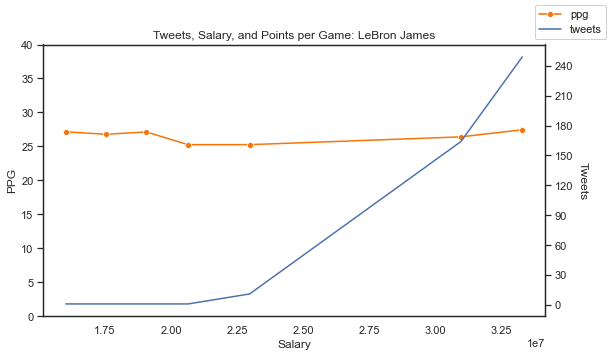

In [24]:
create_and_save_plot('LeBron James', lebron_df)

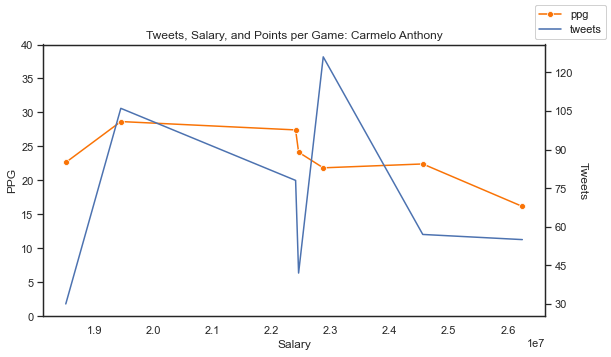

In [25]:
create_and_save_plot('Carmelo Anthony', melo_df)

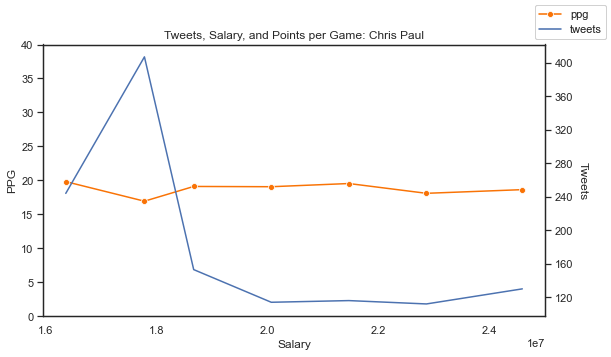

In [26]:
create_and_save_plot('Chris Paul', cp3_df)